In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Make sure target_size matches your model input
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fallen Detection Dataset/train',
    target_size=(128, 128),  # <-- change to 128x128
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Fallen Detection Dataset/val',
    target_size=(128, 128),  # <-- change to 128x128
    batch_size=32,
    class_mode='categorical'
)

Found 1133 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights='imagenet',       # Use pre-trained ImageNet weights
    include_top=False,        # Exclude the default classification head
    input_shape=(128, 128, 3),
    alpha=0.35
)
base_model.trainable = False  # Freeze the base model

# Add custom classifier for fall detection (2 classes: fall / no fall)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
pip install tf2onnx

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import tf2onnx

# --- Callbacks ---
# Save the best model in Keras format first
checkpoint = ModelCheckpoint(
    "best_model.keras",      # Save as Keras model
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
    save_weights_only=False
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# --- Train the model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stop]
)

# --- Convert the best Keras model to ONNX ---
# Load the saved Keras model
model = tf.keras.models.load_model("best_model.keras")

# Define input signature
spec = (tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input"),)

# Convert to ONNX
output_path = "best_model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    output_path=output_path,
    opset=13  # recommended
)

print(f"ONNX model saved to: {output_path}")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.6262 - loss: 0.7412
Epoch 1: val_loss improved from inf to 0.36203, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 31s 660ms/step - accuracy: 0.6279 - loss: 0.7384 - val_accuracy: 0.8125 - val_loss: 0.3620
Epoch 2/50
 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8438 - loss: 0.3293
Epoch 2: val_loss improved from 0.36203 to 0.33390, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8438 - loss: 0.3293 - val_accuracy: 0.8281 - val_loss: 0.3339
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.7949 - loss: 0.4673
Epoch 3: val_loss improved from 0.33390 to 0.28066, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 705ms/step - accuracy: 0.7954 - loss: 0.4666 - val_accuracy: 0.8438 - val_loss: 0.2807
Epoch 4/50
 1/35 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8125 - loss: 0.4060
Epoch 4: val_loss did not improve from 0.28066
35/35 

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7e0d355642c0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


ONNX model saved to: best_model.onnx


In [ ]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [ ]:
import onnxruntime as ort
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
print(train_generator.class_indices)

{'fall': 0, 'not_fall': 1}



Classification Report:
              precision    recall  f1-score   support

        fall       0.95      0.95      0.95        21
    not_fall       0.95      0.95      0.95        20

    accuracy                           0.95        41
   macro avg       0.95      0.95      0.95        41
weighted avg       0.95      0.95      0.95        41



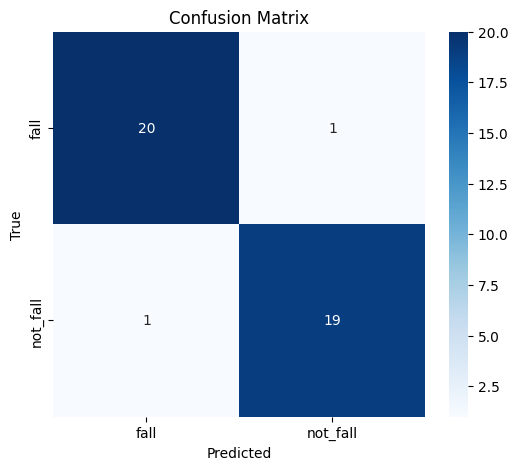

In [ ]:
import numpy as np
import os
from PIL import Image, UnidentifiedImageError
import onnxruntime as ort
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns   # Optional but gives a nice heatmap

# Load ONNX model
onnx_model_path = "best_model.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Get the input name for the ONNX model
input_name = ort_session.get_inputs()[0].name

test_folder = "/content/drive/MyDrive/Fallen Detection Dataset/test"

# Allowed image extensions
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp")

# Class label mapping
class_indices = {"fall": 0, "not_fall": 1}
class_names = ["fall", "not_fall"]

# Store labels for confusion matrix
y_true = []
y_pred = []

for class_name in class_names:
    class_path = os.path.join(test_folder, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Skip hidden files or non-images
        if not img_name.lower().endswith(valid_extensions):
            continue

        try:
            # Resize to model input size
            img = Image.open(img_path).convert("RGB").resize((128, 128))
            img_array = np.expand_dims(np.array(img) / 255.0, axis=0).astype(np.float32)

            # Run ONNX inference
            outputs = ort_session.run(None, {input_name: img_array})
            predicted_class = np.argmax(outputs[0], axis=1)[0]

            y_true.append(class_indices[class_name])
            y_pred.append(predicted_class)

        except UnidentifiedImageError:
            print(f"Skipping unreadable file: {img_path}")

# Calculate accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Classification report (precision, recall, f1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

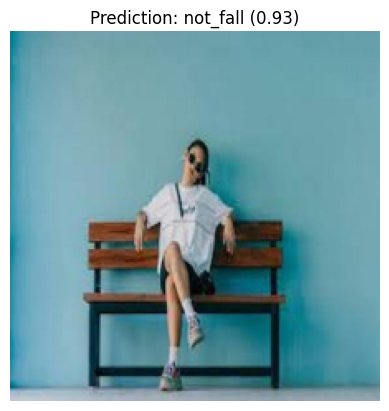

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model("best_model.h5")

# Path to the single test image
image_path = "/content/drive/MyDrive/Fallen Detection Dataset/test/not_fall/not-fallen008_jpg.rf.587801701789db40dd5a97e63d7b9198.jpg"  # change this

# Preprocess the image
img = Image.open(image_path).convert("RGB").resize((224, 224))
img_array = np.expand_dims(np.array(img) / 255.0, axis=0)  # normalize and add batch dimension

# Predict
prediction = model.predict(img_array, verbose=0)
predicted_class = np.argmax(prediction, axis=1)[0]

# Class mapping (from your dictionary)
class_mapping = {0: "fall", 1: "not_fall"}
predicted_label = class_mapping[predicted_class]
confidence = prediction[0][predicted_class]

# Show image with prediction
plt.imshow(img)
plt.title(f"Prediction: {predicted_label} ({confidence:.2f})")
plt.axis("off")
plt.show()


In [ ]:
pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11

In [ ]:
import tf2onnx
import tensorflow as tf

# Load Keras model
model = tf.keras.models.load_model("/content/drive/MyDrive/Fallen Detection Dataset/best_model_fine_tuned.h5")

# Convert to ONNX
spec = (tf.TensorSpec(model.input_shape, tf.float32, name="input"),)
output_path = "best_model_fine_tuned.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c8b3a08f6a0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


In [ ]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00


0.9593471


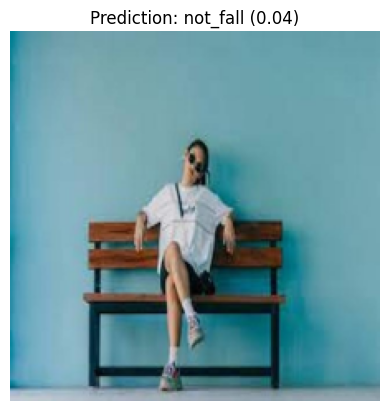

In [ ]:
# the single image with Onnx
import numpy as np
from PIL import Image
import onnxruntime as ort
import matplotlib.pyplot as plt

# ---- Load ONNX model ----
session = ort.InferenceSession("/content/drive/MyDrive/Fallen Detection Dataset/best_model_fine_tuned.onnx")  # your ONNX model
input_name = session.get_inputs()[0].name

# ---- Path to the single test image ----
image_path = "/content/drive/MyDrive/Fallen Detection Dataset/test/not_fall/not-fallen008_jpg.rf.587801701789db40dd5a97e63d7b9198.jpg"

# ---- Preprocess the image ----
img = Image.open(image_path).convert("RGB").resize((224, 224))
img_array = np.array(img).astype(np.float32)

# EfficientNet preprocessing: scale to [-1,1] (same as tf.keras.applications.efficientnet.preprocess_input)
img_array = (img_array / 127.5) - 1.0

# Add batch dimension
img_array = np.expand_dims(img_array, axis=0)

# ---- Predict ----
prediction = session.run(None, {input_name: img_array})[0]

# ---- Postprocess ----
predicted_class = np.argmax(prediction, axis=1)[0]
class_mapping = {0: "fall", 1: "not_fall"}
predicted_label = class_mapping[predicted_class]
confidence = prediction[0][0]
print(1 - confidence)

# ---- Display image with prediction ----
plt.imshow(img)
plt.title(f"Prediction: {predicted_label} ({confidence:.2f})")
plt.axis("off")
plt.show()


In [ ]:
# testing with tflite model
